In [2]:
pwd

'c:\\Users\\Meeth\\CelesDataAnal'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import optimize

START

In [4]:
# Config Data
G = 1.9935608097491742e-38

ELLIPSE SETUP

In [5]:
# given phase input, return conic parameters
def retConicParam(op):
    mu = op['M'] * G
    r = np.copy(op['r'])
    v = np.copy(op['v'])
    vlen = np.linalg.norm(v)
    a = 1/(2/np.linalg.norm(r) - math.pow(vlen,2)/mu)
    print(a, np.linalg.norm(r))
    TP = 2*math.pi*math.sqrt(math.pow(a,3)/mu)
    h = np.linalg.norm(np.cross(r,v))
    ecc= math.sqrt(1 - h*h/(a*mu))
    n = math.sqrt(mu/math.pow(a,3))
    E = math.acos((a - np.linalg.norm(r))/(a*ecc))
    theta = 2 * math.atan(math.sqrt((1+ecc)/(1-ecc)) * math.tan(E/2))
    axisThet = math.atan2(r[1],r[0])
    deltaThet = axisThet - theta
    M = E - ecc*math.sin(E)
    return {'a':a, 'ecc':ecc, 'TP':TP, 'n': n, 'E': E, 'M': M, 'mu': mu, 'theta': theta, 'axisThet': axisThet, 'deltaThet': deltaThet}

Newton Optimiser Step

In [6]:
def f(M, ecc):
    return lambda x: x - ecc * math.sin(x) - M

def fPrime(ecc):
    return lambda x: 1 - ecc * math.cos(x)

In [7]:
def conicPts(n, ecc, M,E, step):
    M1 = M + n*step
    E1 = optimize.newton(f(M1, ecc), E, fPrime(ecc))
    return E1

In [8]:
# return position of object given conic parameters and iterated vaue of E
def retPos(a, ecc, E, mu, deltaThet):
    r = a * (1 - ecc * math.cos(E))
    theta = 2*math.atan(math.sqrt((1+ecc)/(1-ecc)) * math.tan(E/2))
    return np.array([r*math.cos(theta+deltaThet), r*math.sin(theta+deltaThet)])

In [9]:
# returns all the points broken into N pieces
def getPts(parameters, r, N):
    step = parameters['TP']/N
    n = parameters['n']
    ecc = parameters['ecc']
    M = parameters['M']
    E = parameters['E']
    a = parameters['a']
    deltaThet = parameters['deltaThet']
    pnt = [np.copy(r)]
    print(pnt)
    mu = parameters['mu']
    for i in range(math.floor(N)):
        # M1 = M + n*step
        E1 = conicPts(n, ecc, M, E, step)
        r1 = retPos(a, ecc, E1, mu, deltaThet)
        E = E1
        M = E - ecc*math.sin(E)
        pnt = np.append(pnt, [np.copy(r1)], axis=0)
    return pnt
        

    

Execution

In [10]:
op = {'M': 9e30, 'r': np.array([11.89203237965344,59.17526544546777]), 'v': np.array([-0.00006254039044674874, 0.000027661858645905403])}
parameters = retConicParam(op)
parameters

141.4213562373095 60.35836706422978


{'a': 141.4213562373095,
 'ecc': 0.6,
 'TP': 24946887.38886774,
 'n': 2.5186249527800355e-07,
 'E': 0.30000000000000016,
 'M': 0.12268787600319633,
 'mu': 1.7942047287742567e-07,
 'theta': 0.5870769191406715,
 'axisThet': 1.3724750825381193,
 'deltaThet': 0.7853981633974478}

In [11]:
fpnts = getPts(parameters, op['r'], 5000)

[array([11.89203238, 59.17526545])]


(-200.8687303668286, 80.86869846389305, -200.86872450090658, 80.86873220937906)

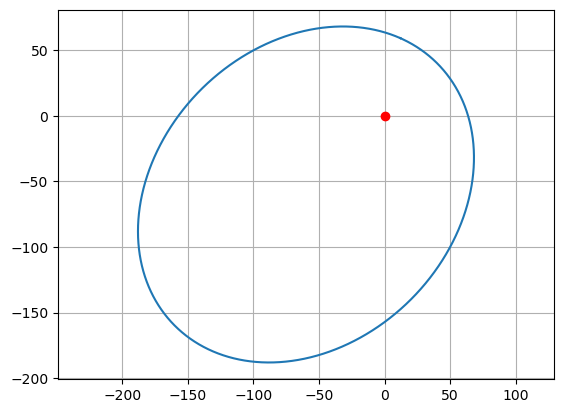

In [12]:
df = pd.DataFrame(columns=['x', 'y'])
df['x'] = fpnts[:, 0]
df['y'] = fpnts[:, 1]
plt.plot(df['x'], df['y']) 
plt.plot(0,0, 'ro')
plt.grid()
plt.axis('equal')

HYPOERBOLIC SETUP

In [13]:
# given phase input, return conic parameters
def retConicParamH(op):
    mu = op['M'] * G
    r = np.copy(op['r'])
    v = np.copy(op['v'])
    vlen = np.linalg.norm(v)
    a = 1/(2/np.linalg.norm(r) - math.pow(vlen,2)/mu)
    n = math.sqrt(mu/math.pow(-a,3))
    h = np.linalg.norm(np.cross(r,v))
    ecc= math.sqrt(1 - h*h/(a*mu))
    F = math.acosh((1 - np.linalg.norm(r)/a)/ecc) 
    thet = 2*math.atan(math.sqrt((1+ecc)/(ecc-1)) * math.tanh(F/2))
    axisThet = math.acos(np.dot(r, [1,0])/np.linalg.norm(r))
    deltaThet = axisThet - thet
    M = ecc*math.sinh(F) - F 
    return {'a':a, 'ecc':ecc, 'n':n, 'F': F, 'M': M, 'mu': mu, 'h':h, 'thet':thet, 'axisThet':axisThet, 'deltaThet':deltaThet}

In [14]:
def fH(M, ecc):
    return lambda x: ecc * math.sinh(x) - x - M

def fHPrime(ecc):
    return lambda x: ecc * math.cosh(x) - 1

In [15]:
def conicPtsH(n, ecc, M,F, step):
    M1 = M + n*step
    F1 = optimize.newton(fH(M1, ecc), F, fHPrime(ecc))
    return F1

In [16]:
# return position of object given conic parameters and iterated vaue of E
def retPosH(a, ecc, F, mu, delThet):
    r = -1 * a * ( ecc * math.cosh(F) - 1)
    theta = 2*math.atan(math.sqrt((1+ecc)/(ecc - 1)) * math.tanh(F/2))
    # rotation_matrix = np.array([[np.cos(delThet), -np.sin(delThet)],
    #                         [np.sin(delThet), np.cos(delThet)]])
    # return np.dot(rotation_matrix, np.array([r*math.cos(theta), r*math.sin(theta)]))
    return np.array([r*math.cos(theta+delThet), r*math.sin(theta+delThet)])

In [17]:
# returns all the points broken into N pieces
def getPtsH(parameters, r, N):
    n = parameters['n']
    step = math.pi*2/(n*N) 
    ecc = parameters['ecc']
    M = parameters['M']
    F = parameters['F']
    a = parameters['a']
    delThet = parameters['deltaThet']
    pnt = [np.copy(r)]
    # print(pnt)
    mu = parameters['mu']
    # print(step)
    for i in range(math.floor(N/10)):
        F1 = conicPtsH(n, ecc, M, F, step)
        r1 = retPosH(a, ecc, F1, mu, delThet)
        F = F1
        M = ecc*math.sinh(F) - F
        pnt = np.append(pnt, [np.copy(r1)], axis=0)
    return pnt

def getPtsHRev(parameters, r, N, pnt):
    n = parameters['n']
    step = math.pi*2/(n*N) 
    ecc = parameters['ecc']
    M = parameters['M']
    F = parameters['F']
    a = parameters['a']
    delThet = parameters['deltaThet']
    pnt = pnt
    # print(pnt)
    mu = parameters['mu']
    # print(step)
    for i in range(math.floor(N/10)):
        F1 = conicPtsH(n, ecc, M, F, (-1)*step)
        r1 = retPosH(a, ecc, F1, mu, delThet)
        F = F1
        M = ecc*math.sinh(F) - F
        pnt = np.append(pnt, [np.copy(r1)], axis=0)
    return pnt

In [18]:
# opH = {'M': 9e30, 'r': np.array([140,0]), 'v': np.array([0, 0.000051])}
opH = {'M': 9e30,  'r': np.array([11.89203237965344,59.17526544546777]), 'v': np.array([-0.00006254039044674874, 0.000047661858645905403])}
parametersH = retConicParamH(opH)
parametersH

{'a': -754.5649816865642,
 'ecc': 1.065141421242492,
 'n': 2.0435771074563306e-08,
 'F': 0.16678783645375622,
 'M': 0.011689605336167253,
 'mu': 1.7942047287742567e-07,
 'h': 0.004267640572041126,
 'thet': 0.8762028687107555,
 'axisThet': 1.3724750825381193,
 'deltaThet': 0.49627221382736386}

In [19]:
fpntsH = getPtsH(parametersH, opH['r'], 5000)
fpntsH = getPtsHRev(parametersH, opH['r'], 5000, fpntsH)

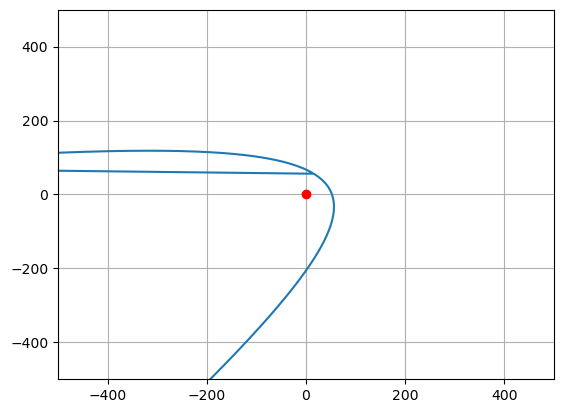

In [20]:
dfH = pd.DataFrame(columns=['x', 'y'])
dfH['x'] = fpntsH[:, 0]
dfH['y'] = fpntsH[:, 1]
plt.plot(dfH['x'], dfH['y'])
plt.plot(0,0, 'ro')
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.grid()
# plt.axis('equal')
